# 0. Color Map encoder

low/high quality input 都是转成了color map的形式

In [1]:
import torch.nn as nn
import torch

import torch.nn.functional as F

class Conv2D(nn.Module):
    def __init__(self, in_channels, out_channels, activation='lrelu', stride=1):
        super().__init__()
        self.ActivationLayer = nn.LeakyReLU(inplace=True)
        if activation == 'relu':
            self.ActivationLayer = nn.ReLU(inplace=True)
        self.conv_relu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            self.ActivationLayer,
        )

    def forward(self, x):
        return self.conv_relu(x)
class MaxPooling2D(nn.Module):
    def __init__(self, kernel_size=2, stride=2):
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride)

    def forward(self, x):
        return self.maxpool(x)


class AvgPooling2D(nn.Module):
    def __init__(self, kernel_size=2, stride=2):
        super().__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        return self.avgpool(x)

class ConvTranspose2D(nn.Module):
    def __init__(self, in_channels, out_channels, activation='lrelu'):
        super().__init__()
        self.ActivationLayer = nn.LeakyReLU(inplace=True)
        if activation == 'relu':
            self.ActivationLayer = nn.ReLU(inplace=True)
        self.deconv_relu = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0),
            self.ActivationLayer,
        )

    def forward(self, x):
        return self.deconv_relu(x)    
class Concat(nn.Module):
    def forward(self, x, y):
        _, _, xh, xw = x.size()
        _, _, yh, yw = y.size()
        diffY = xh - yh
        diffX = xw - yw
        y = F.pad(y, (diffX // 2, diffX - diffX//2,
                      diffY // 2, diffY - diffY//2))
        return torch.cat((x, y), dim=1)    
class ColorEncoder(nn.Module):
    def __init__(self, nf, opt=None):
        self.opt = opt
        super(ColorEncoder, self).__init__()
        self.conv_input = Conv2D(3, nf)
        # top path build Reflectance map
        self.maxpool_r1 = MaxPooling2D()
        self.conv_r1 = Conv2D(nf, nf * 2)
        self.maxpool_r2 = MaxPooling2D()
        self.conv_r2 = Conv2D(nf * 2, nf * 4)
        self.deconv_r1 = ConvTranspose2D(nf * 4, nf * 2)
        self.concat_r1 = Concat()
        self.conv_r3 = Conv2D(nf * 4, nf * 2)
        self.deconv_r2 = ConvTranspose2D(nf * 2, nf)
        self.concat_r2 = Concat()
        self.conv_r4 = Conv2D(nf * 2, nf)
        self.conv_r5 = nn.Conv2d(nf, 3, kernel_size=3, padding=1)
        # self.R_out = nn.Sigmoid()
        self.R_out = nn.Sigmoid()# (negative_slope=0.2, inplace=True)
        # bottom path build Illumination map
        # self.conv_i1 = Conv2D(nf, nf)
        # self.concat_i1 = Concat()
        # self.conv_i2 = nn.Conv2d(nf * 2, 1, kernel_size=3, padding=1)
        # self.I_out = nn.Sigmoid()

    def forward(self, x, get_steps=False):
        assert not get_steps

        # x = torch.cat([x, color_x], dim=1)
        conv_input = self.conv_input(x)
        # build Reflectance map
        maxpool_r1 = self.maxpool_r1(conv_input)
        conv_r1 = self.conv_r1(maxpool_r1)
        maxpool_r2 = self.maxpool_r2(conv_r1)
        conv_r2 = self.conv_r2(maxpool_r2)
        deconv_r1 = self.deconv_r1(conv_r2)
        concat_r1 = self.concat_r1(conv_r1, deconv_r1)
        conv_r3 = self.conv_r3(concat_r1)
        deconv_r2 = self.deconv_r2(conv_r3)
        concat_r2 = self.concat_r2(conv_input, deconv_r2)
        conv_r4 = self.conv_r4(concat_r2)
        conv_r5 = self.conv_r5(conv_r4)
        R_out = self.R_out(conv_r5)
        color_x = nn.functional.avg_pool2d(R_out,16, 1, 16//2)
        # color_x = color_x / torch.sum(color_x, 1, keepdim=True)
        # build Illumination map
        # conv_i1 = self.conv_i1(conv_input)
        # concat_i1 = self.concat_i1(conv_r4, conv_i1)
        # conv_i2 = self.conv_i2(concat_i1)
        # I_out = self.I_out(conv_i2)

        return conv_input, maxpool_r1, maxpool_r2, conv_r2, conv_r3, conv_r4, conv_r5, R_out, color_x

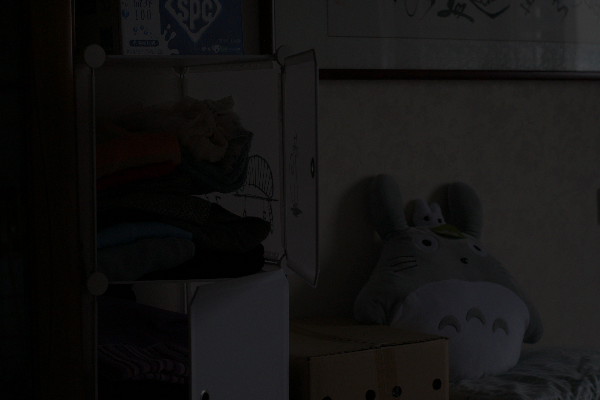

In [105]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('./low/22.png')
import torchvision.transforms as transforms
transform = transforms.ToTensor()
x = transform(img)
x = x.unsqueeze(0)
x_input = x
img

In [11]:
import pywt
import torch
def dwt_init(x): #1, 3, 400, 600
    x01 = x[:, :, 0::2, :] / 2
    x02 = x[:, :, 1::2, :] / 2
    x1 = x01[:, :, :, 0::2]
    x2 = x02[:, :, :, 0::2]
    x3 = x01[:, :, :, 1::2]
    x4 = x02[:, :, :, 1::2]
    x_LL = x1 + x2 + x3 + x4
    x_HL = -x1 - x2 + x3 + x4
    x_LH = -x1 + x2 - x3 + x4
    x_HH = x1 - x2 - x3 + x4
    # print(x_HH[:, 0, :, :])
    return torch.cat((x_LL, x_HL, x_LH, x_HH), 1)

dwt_res = dwt_init(x)

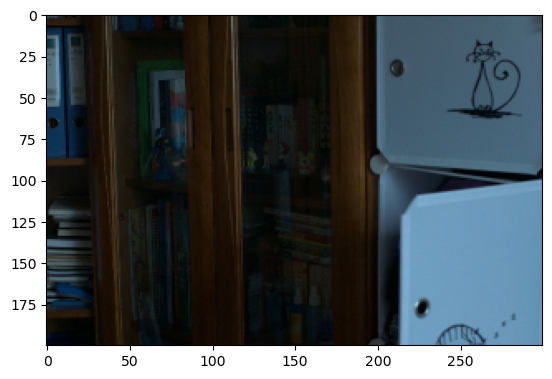

In [17]:
plt.imshow(dwt_res[0, 0:3, :, :].permute(1,2,0).numpy())

In [156]:
from pytorch_wavelets import DWT1DForward, DWT1DInverse, DWTForward, DWTInverse, DTCWTForward, DTCWTInverse
import torch.nn as nn
def bili_resize(factor):
    return nn.Upsample(scale_factor=factor, mode='bilinear', align_corners=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


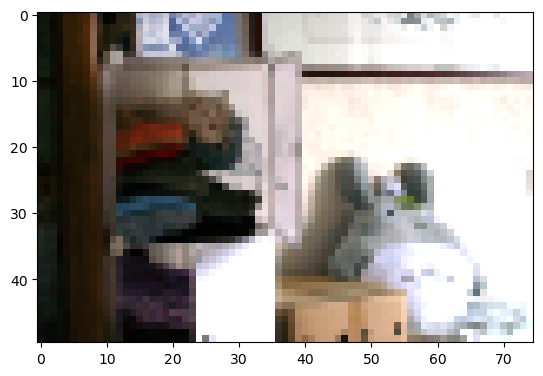

In [213]:
dwt = DWTForward(J=3, mode = 'zero')
iwt = DWTInverse(mode='zero')
dwt1, dwt2 = dwt(x)
plt.imshow(dwt1[0].permute(1,2,0,).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


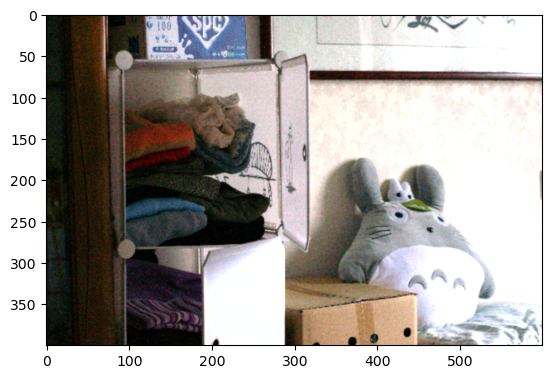

In [214]:
upsample = bili_resize(2)
x_big = upsample(upsample(upsample(x)))
dwt1, dwt2 = dwt(x_big)
plt.imshow(dwt1[0].permute(1,2,0,).numpy())

In [204]:
# dwt(x)[0].shape #(1,nf, H/8, W/8)

# dwt()[1][1].shape #(1,nf, 3, H/2, W/2), (1,nf, 3, H/4, W/4), (1,nf, 3, H/8, W/8)
upsample = bili_resize(2)
downscale = bili_resize(0.5)
test_mix = upsample(dwt1)* 0.7 + downscale(downscale(x)) * 0.3
plt.imshow(test_mix[0].permute(1,2,0).numpy())


RuntimeError: The size of tensor a (300) must match the size of tensor b (150) at non-singleton dimension 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


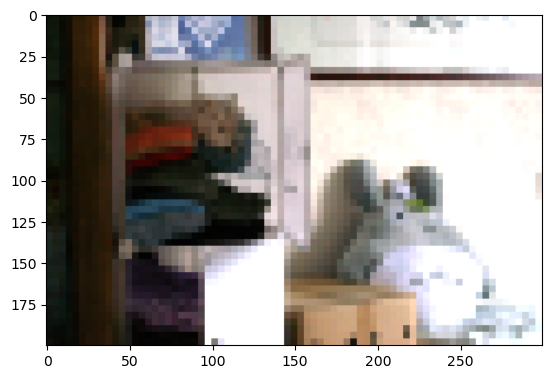

In [155]:
from torch.nn import functional as F
plt.imshow(F.interpolate(F.interpolate(dwt1, scale_factor = 2), scale_factor = 2)[0].permute(1,2,0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


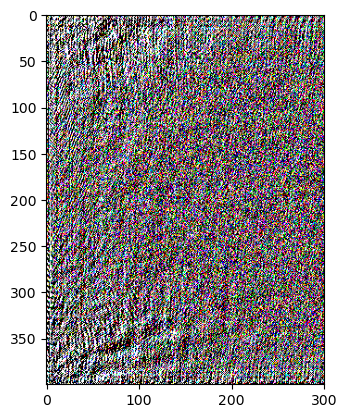

In [146]:
y = torch.fft.rfft2(x, norm='backward')
plt.imshow(y.real[0].permute(1,2,0).numpy())

In [147]:
y.real.shape

torch.Size([1, 3, 400, 301])

In [4]:
gt = Image.open('./high/1.png')
# gt = io.imread('./high/1.png')
gt = transform(gt)

In [5]:
CE = ColorEncoder(nf = 64)
conv_input, maxpool_r1, maxpool_r2, conv_r2, conv_r3, conv_r4, conv_r5, R_out, color_x = CE(x)

conv_r5, R_out 这两个应该是能反应color map的，但是一开始还是黑/灰的，要逐渐训练才有

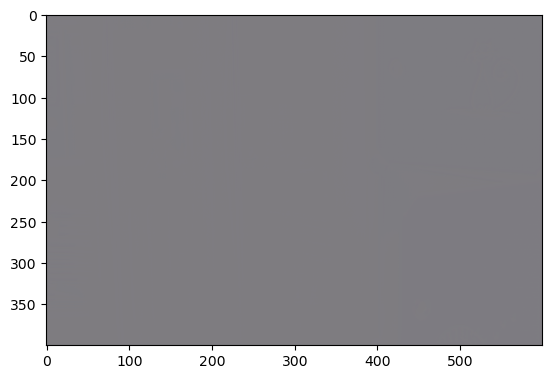

In [6]:
plt.imshow(R_out[0].permute(1,2,0).detach().numpy())

In [7]:
#gt的color map
color_gt = nn.functional.avg_pool2d(x, 11, 1, 5)
color_gt = color_gt / torch.sum(color_gt, 1, keepdim=True)

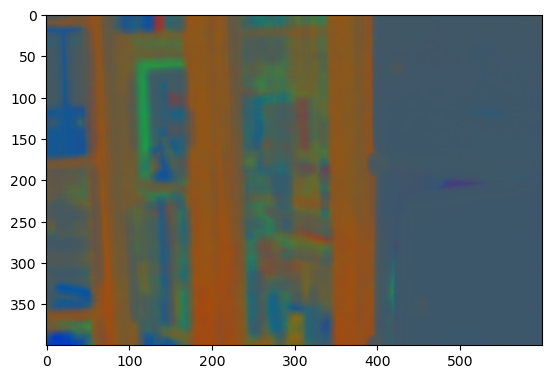

In [8]:
plt.imshow(color_gt[0].permute(1,2,0).numpy())

In [36]:
torch.zeros_like(x[:, 0, 0, 0])

tensor([0.])

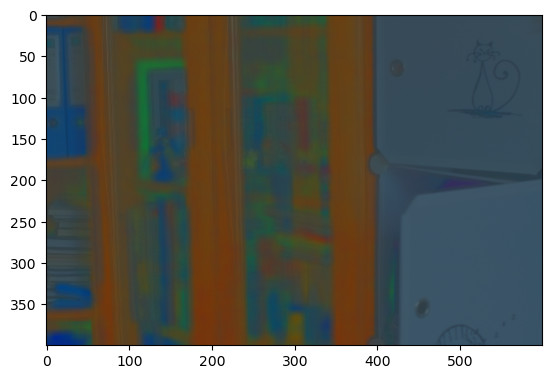

In [17]:
enhanced = 0.3*x+0.7*color_gt
plt.imshow(enhanced[0].permute(1,2,0).numpy())

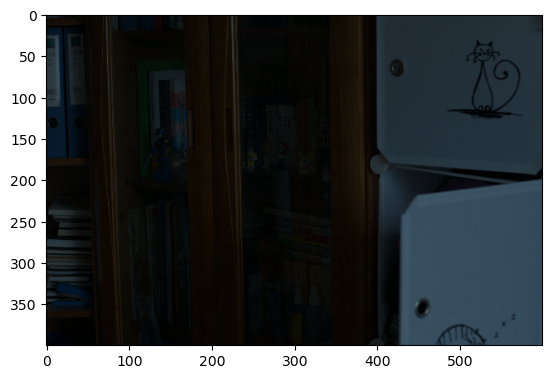

In [11]:
plt.imshow(x[0].permute(1,2,0).numpy())
# x.shape

In [39]:
from skimage import io, metrics, exposure


def PSNR_SSIM(low, high):
    
    if low.shape[-1]!=3:
        low = low.permute(1,2,0)
    if high.shape[-1]!=3:
        high = high.permute(1,2,0)
    if type(low)==torch.Tensor:
        low = low.numpy()
        high = high.numpy()
    psnr = metrics.peak_signal_noise_ratio(low, high)
    ssim = metrics.structural_similarity(low, high, multichannel=True)
    return psnr, ssim
print(PSNR_SSIM(enhanced[0], gt))

(9.55971492346653, 0.62823)


/tmp/ipykernel_956902/2086506092.py:14: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = metrics.structural_similarity(low, high, multichannel=True)


In [38]:
type(gt)==torch.Tensor

True

In [92]:
x_eq = exposure.equalize_hist(x[0].permute(1,2,0).numpy(), nbins=256)

/workspace/AdBRC/tszhang/anaconda3/envs/py39/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


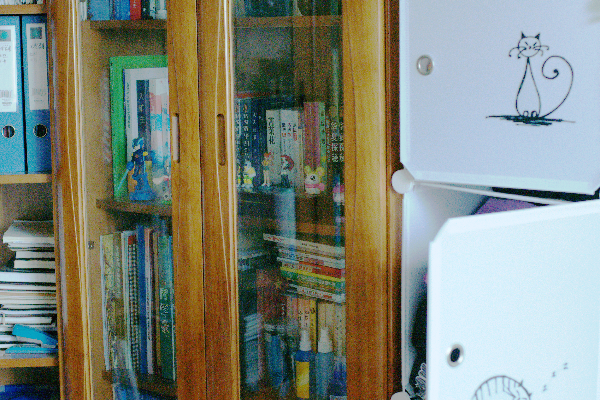

In [101]:
Image.fromarray((x_eq*255).astype(np.uint8))

## 0.2 直方图均衡+color_gt 会导致过曝，反倒效果不好

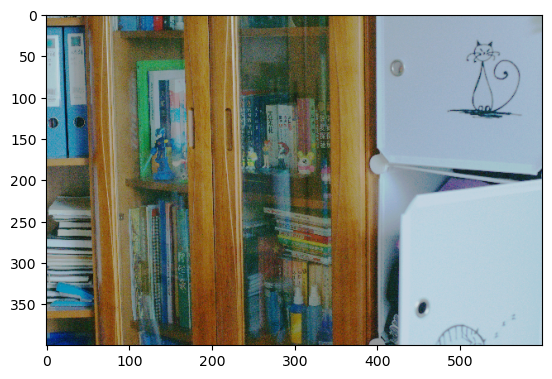

In [94]:
# x_eq = x_eq.astype(np.float64)
x_eq_gt = 0.8 * x_eq + 0.2 * color_gt[0].permute(1,2,0).numpy()
plt.imshow(x_eq_gt)


In [95]:
psnr = metrics.peak_signal_noise_ratio(np.clip(x_eq_gt,0,1), gt.permute(1,2,0).numpy())
ssim = metrics.structural_similarity(np.clip(x_eq_gt,0,1), gt.permute(1,2,0).numpy(), multichannel=True)
print([psnr, ssim])

[20.168042383818523, 0.80689985]


/tmp/ipykernel_956902/2002890315.py:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = metrics.structural_similarity(np.clip(x_eq_gt,0,1), gt.permute(1,2,0).numpy(), multichannel=True)


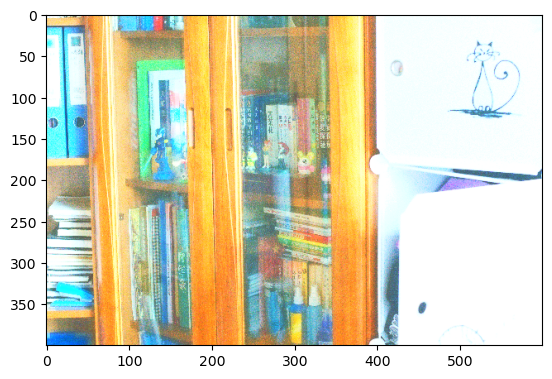

In [106]:
import numpy as np
plt.imshow(np.clip(x_eq_gt,0,1))

In [65]:
metrics.peak_signal_noise_ratio(np.clip(x_eq_gt,0,1), gt.permute(1,2,0).numpy())
# metrics.structural_similarity(np.clip(x_eq_gt,0,1), gt.permute(1,2,0).numpy(), multichannel=True)

/tmp/ipykernel_956902/265093804.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  metrics.peak_signal_noise_ratio(np.clip(x_eq_gt,0,1), gt.permute(1,2,0).numpy())


15.59037102681745